In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import statsmodels.stats.api as sms


class DataLoader:
    """
    Class responsible for loading data from an SQLite database.

    Attributes:
        db_path (str): Path to the SQLite database.
        dataframes (dict): Dictionary containing the loaded DataFrames.
    """

    def __init__(self, db_path: str):
        """
        Initialize the DataLoader class with a database path.

        Args:
            db_path (str): Path to the SQLite database.
        """
        self.db_path = db_path
        self.dataframes = {}

    def load_data(self) -> dict:
        """
        Load data from the SQLite database and store it in a dictionary.

        Returns:
            dict: A dictionary whose keys are table names and values are the corresponding DataFrames.
        """
        connection = sqlite3.connect(self.db_path)
        tables = [
            "drivers",
            "fcyphases",
            "laps",
            "qualifyings",
            "races",
            "retirements",
            "starterfields",
        ]
        self.dataframes = {
            table: pd.read_sql_query(f"SELECT * FROM {table}", connection)
            for table in tables
        }
        connection.close()
        return self.dataframes


class F1Team:
    """
    Class for data preparation and regression analysis for a given driver
    for a specific season and race.

    Attributes:
        season (int): Season to analyze.
        driver_id (int): ID of the driver.
        race_id (int): ID of the target race for testing.
        dfs (dict): Dictionary of DataFrames.
        best_qualif_times (pd.DataFrame): DataFrame with best qualifying times per race.
        train_data (pd.DataFrame): Training dataset.
        test_data (pd.DataFrame): Test dataset.
        model: Trained regression model.
        predictions (pd.Series): Predictions generated by the model on the test data.
    """

    def __init__(self, team : str,season: int, dataframes: dict):
        """
        Initialize the F1Model class.

        Args:
            season (int): Season to analyze.
            driver_id (int): ID of the driver to analyze.
            race_id (int): ID of the race used for testing.
            dataframes (dict): Dictionary of DataFrames containing the data.
        """
        self.dfs = dataframes
        self.team = team
        self.season=season
        self.drivers_if_of_the_season = self._load_season_team_drivers()
        self.dfs = dataframes



    
    def _load_season_team_drivers(self):
        race_ids_season = self.dfs["races"][self.dfs["races"]["season"] == self.season]["id"]

        staterfields_df=self.dfs["staterfields"]
        staterfields_df[(staterfields_df["race_id"].isin(race_ids_season))&(staterfields_df)]

    def get_pit_stop_avg(self):
        pass

def main():
    
    # Load data
    db_path = "F1_timingdata_2014_2019.sqlite"
    data_loader = DataLoader(db_path=db_path)
    dataframes = data_loader.load_data()
    

    


if __name__ == "__main__":
    main()


In [4]:
db_path = "F1_timingdata_2014_2019.sqlite"
data_loader = DataLoader(db_path=db_path)
dataframes = data_loader.load_data()
dataframes.keys()

dict_keys(['drivers', 'fcyphases', 'laps', 'qualifyings', 'races', 'retirements', 'starterfields'])

In [18]:
df_laps = dataframes['laps']
race_id=12
dfs_laps[dfs_laps["race_id"]==race_id]

,race_id,lapno,position,driver_id,laptime,racetime,gap,interval,compound,tireage,pitintime,pitstopduration,nextcompound,startlapprog_vsc,endlapprog_vsc,age_vsc,startlapprog_sc,endlapprog_sc,age_sc
13105,12,0,1,3,NaN,0.000,NaN,NaN,A3,2,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13106,12,0,2,1,NaN,0.000,NaN,NaN,A3,2,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13107,12,0,3,12,NaN,0.000,NaN,NaN,A3,2,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13108,12,0,4,5,NaN,0.000,NaN,NaN,A3,2,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13109,12,0,5,2,NaN,0.000,NaN,NaN,A3,2,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13980,12,44,11,7,115.597,5142.253,65.697,0.350,A3,14,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13981,12,44,12,6,115.567,5148.476,71.920,6.223,A3,15,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13982,12,44,13,9,114.543,5152.531,75.975,4.055,A3,9,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
13983,12,44,14,13,114.182,5159.003,82.447,6.472,A3,10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_races = dataframes['races']
race_id=12
len_train_df=2
current_season = 2016
location = df_races[df_races['id']==race_id]['location'].iloc[0]
seasons_to_train = [current_season - x for x in range (1, len_train_df +1)]
races_to_train = list(df_races[(df_races['location']==location) & (df_races['season'].isin(seasons_to_train))]['id'])
races_to_train

[12, 30]

,id,date,season,location,availablecompounds,comment,nolaps,nolapsplanned,tracklength
0,1,2014-03-16,2014,Melbourne,"A2,A3,I,W",None,57,58,5303.0
1,2,2014-03-30,2014,KualaLumpur,"A1,A2,I,W",None,56,56,5543.0
2,3,2014-04-06,2014,Sakhir,"A2,A3,I,W","Crash GUT in lap 41, SC somewhen in the end of...",57,57,5412.0
3,4,2014-04-20,2014,Shanghai,"A2,A3,I,W",None,54,56,5451.0
4,5,2014-05-11,2014,Catalunya,"A1,A2,I,W",None,66,66,4655.0
...,...,...,...,...,...,...,...,...,...
116,117,2019-10-13,2019,Suzuka,"A2,A3,A4,I,W",None,52,53,5807.0
117,118,2019-10-27,2019,MexicoCity,"A3,A4,A6,I,W",None,71,71,4304.0
118,119,2019-11-03,2019,Austin,"A3,A4,A6,I,W",None,56,56,5513.0
119,120,2019-11-17,2019,SaoPaulo,"A2,A3,A4,I,W",None,71,71,4309.0


array([<Axes: title={'center': '12'}>, <Axes: title={'center': '30'}>],
      dtype=object)

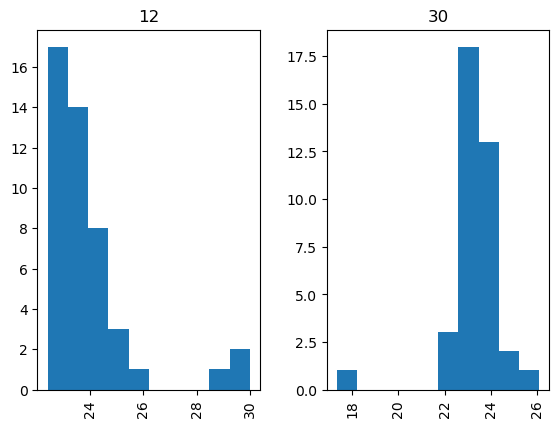

In [28]:
df_laps[dfs_laps['race_id'].isin(races_to_train)].dropna(subset=['pitstopduration']).hist('pitstopduration', by='race_id')

In [35]:
min_pit_stop_duration_per_race = df_laps[dfs_laps['race_id'].isin(races_to_train)].dropna(subset=['pitstopduration']).groupby(['race_id'])[['pitstopduration']].quantile(q=0.025)
avg_min_pit_stop_duration = min_pit_stop_duration_per_race['pitstopduration'].mean()

22.3111875

In [ ]:
from scipy.stats import fisk
import pandas as pd
from team import Team

class PitStop():
    def __init__(self, Team, race_id, len_train_df, season, dataframes):
        self.Team = Team
        self.race_id=race_id
        self.len_train_df = len_train_df
        self.season = season
        self.dfs = dataframes
        

    def calculate_best_pit_stop_duration():
        df_races = self.dfs['races']
        location = df_races[df_races['id']==self.race_id]['location'].iloc[0]
        seasons_to_train = [self.season - x for x in range (1, self.len_train_df +1)]
        races_to_train = list(df_races[(df_races['location']==location) & (df_races['season'].isin(seasons_to_train))]['id'])
        min_pit_stop_duration_per_race = df_laps[dfs_laps['race_id'].isin(races_to_train)].dropna(subset=['pitstopduration']).groupby(['race_id'])[['pitstopduration']].quantile(q=0.025)
        avg_min_pit_stop_duration = min_pit_stop_duration_per_race['pitstopduration'].mean()
        self.avg_min_pit_stop_duration = avg_min_pit_stop_duration

    def calibrate_pit_stop_variability_law(self):
        # Recuperer les parametres a partir des data
        # pour chaque team sur la saison on fait pitstop_duration - minimum  et on fit une loi de Fisk
        return [shape, loc, scale]

    def calculate_pit_stop_duration(self):
        shape, loc, scale = self.calibrate_pit_stop_variability_law()
        variability = fisk.rvs(c, loc=0, scale=1, size=1, random_state=None)
        pit_stop = self.avg_min_pit_stop_duration + variability
        return pit_stop
        


In [ ]:
class DNF():
    def __init__(self, season, dataframes, driver, team):
        pass

    def calculate_accident_probability(self):
        # Depend du driver
        # On prend les courses du drivers de N saisons et recupere la frequences d'accidents
        pass

    def calculate_failure_probability(self):
        # Depend de la team et de la saison
        # On prend les courses de la team sur la saison actuelle et recupere la frequences de failures
        pass

